# Predicting fuel efficiency based on car attributes

In [871]:
import tensorflow as tf
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import train_test_split

In [872]:
#Download URL
url = "https://storage.googleapis.com/tfjs-tutorials/carsData.json"
local_file_path = "carsData.json"

#Download the file
response = requests.get(url)
with open(local_file_path,"w") as file:
    file.write(response.text)

# #Store the file in a local variable
# with tf.io.gfile.GFile(local_file_path,"r") as f:
#     data = f.read()
df =pd.read_json(local_file_path)

### Cleaning data

#### Extract the necessary data

In [873]:
#Extract only the data you need.
df= df[["Horsepower","Miles_per_Gallon"]]
print(df)

     Horsepower  Miles_per_Gallon
0         130.0              18.0
1         165.0              15.0
2         150.0              18.0
3         150.0              16.0
4         140.0              17.0
..          ...               ...
401        86.0              27.0
402        52.0              44.0
403        84.0              32.0
404        79.0              28.0
405        82.0              31.0

[406 rows x 2 columns]


#### Check for duplicates

In [874]:
duplicate = df.duplicated().sum()

if duplicate > 0 :
    df = df.drop_duplicates()
    print("Duplicates removed. New dataframe length", len(df))
else:
    print("No duplicates found")

Duplicates removed. New dataframe length 345


#### Remove Errors

In [875]:
if df.isnull().any().any():
     df = df.dropna()
     print("Null values detected, remove the corresponding row...")
else:
     print("Nulls not found")

Null values detected, remove the corresponding row...


### Setup data for training
- <code>shuffled_df = df.sample(frac=1,random_state=42).reset_index(drop=True)</code>
    - Shuffles all rows of the <code>df</code> dataframe to randomize the order of samples. 

    - <code>frac=1</code> returns 100% of the rows in the original DataFrame (0.5 => 50%)
    
    - The <code>random_state=42</code> ensures reproducibility, where the shuffled order remain the same regardless of multiple runs.
    - <code>.reset_index(drop=True)</code> ensures <code>shuffled_df</code> has a sequential index starting from 0 without retaining the original index as a column

- <code>MinMaxScaler</code> scales all numerical columns to a range of [0,1], which ensures consistent feature scaling => Prevents larger numerical ranges from dominating the learning process

- <code>train_test_split(...)</code>: splits the normalized data into <b>training</b> (75%) and <b>testing </b> (25%) sets. This is crucial for evaluating model performance on <b>unseen data</b>

In [876]:
#Shuffle the dataframe
shuffled_df = df.sample(frac=1,random_state=42).reset_index(drop=True)
#label = ["Horsepower","Miles per Gallon"]

#Normalization
scaler= MinMaxScaler()
normalized = scaler.fit_transform(shuffled_df)
normalized_df = pd.DataFrame(normalized, columns=df.columns)

#extract normalized data for training
x_train = normalized_df['Horsepower']
y_train = normalized_df['Miles_per_Gallon']

#save for testing
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.25,random_state=42)

#Convert to a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train.values,y_train.values))

#Get a batch size of 25 
dataset = dataset.batch(25)

# print("Column names:", label)
# for feature,label in dataset:
#    print("Feature and label data:", (feature.numpy(),label.numpy()))


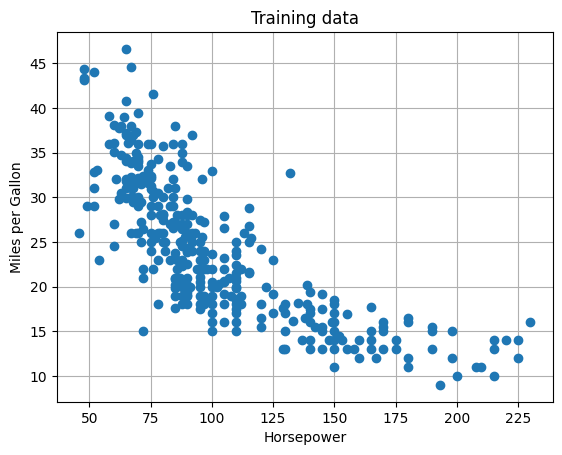

In [877]:
x = df.Horsepower
y = df.Miles_per_Gallon

plt.plot(x,y, 'o')
plt.xlabel("Horsepower")
plt.ylabel("Miles per Gallon")
plt.title("Training data")
plt.grid(True)
plt.show()

#### Model constructing

<code>kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)</code>

- <b>Regularization</b> helps prevent overfitting by adding penalties to the loss function during training.
    - <b>L1 Regularization (l1)</b>
        - Adds a penalty proportional to the <b>absolute values</b> of the weights
        $$ \text{L1 penalty} = 0.01 \times \sum |w| $$

        - Encourages sparsity (where most of the elements in a dataset, feature set, or model parameters (like weights) are zero or have negligible values), pushing some weights to be exactly 0.

    - <b>L2 Regularization l(2)</b>
        - Adds a penalty proportional to the <b>squared values</b> of the weights.
        $$ \text{L2 penalty} = 0.01 \times \sum w^2 $$
        - Helps keep weights small, reducing the change of overfitting 

In [878]:
model = tf.keras.Sequential() 
#This explicitly states that the layer expects input with one feature (1D array) 
#The 2^5 architecture
#model.add(layers.Dense(units=64, input_shape=[1],activation='elu')) 
model.add(layers.Dense(units=32, input_shape=[1],activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))  
model.add(layers.Dense(units=16, input_shape=[1],activation='elu')) 

model.add(layers.Dropout(0.05)) 

model.add(layers.Dense(units=8, input_shape=[1],activation='elu')) 
model.add(layers.Dense(units=4, input_shape=[1],activation='relu')) 

model.add(layers.Dropout(0.05)) 

model.add(layers.Dense(units=2, input_shape=[1],activation='elu')) 
model.add(layers.Dense(units=1,input_shape=[1],use_bias=True))

 #Compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.Huber(delta=1.0)) 

 #With 100 epochs, the model revisits the training data 100 times, gradually reducing the loss and improving accuracy.
history = model.fit(dataset, epochs=100) 

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 0.1881
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.1621
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.1418
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.1255
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.1130
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.1028
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0988
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 0.0902
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.0860
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.0837
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.0811
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.0772
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0705
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.0679
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step -

#### Tracking losses

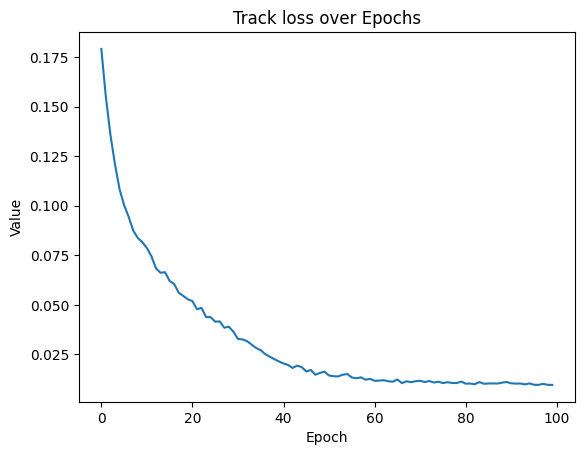

In [879]:
plt.plot(history.history['loss'])
plt.title('Track loss over Epochs') 
plt.xlabel('Epoch') 
plt.ylabel('Value') 
plt.show() 
#for value in history.history['loss']: 
# print("loss: " + str(value))
# #the testing data should be normalized if your model was trained on normalized data 
#test_loss = model.evaluate(x_test, y_test) 
#   print(f'\nTest loss: {test_loss}')|

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
   Actual  Predicted
0    26.0  30.663135
1    29.0  25.943312
2    22.0  20.057371
3    15.0  16.477213
4    13.0  15.135624


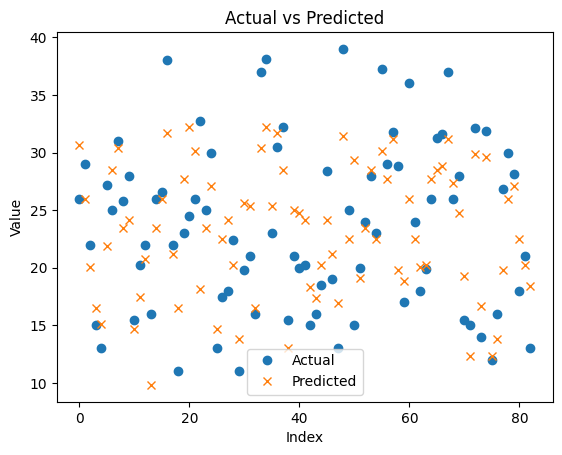

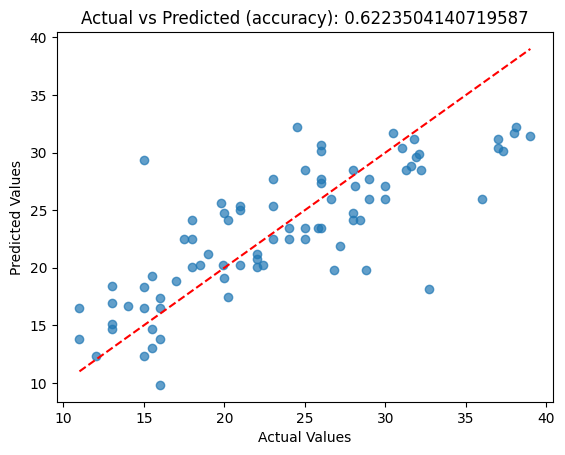

In [880]:
#Setup for un-normalization
labelMin = shuffled_df['Miles_per_Gallon'].min()
labelMax = shuffled_df['Miles_per_Gallon'].max()

#Verification for accuracy

#IN TERMS OF INDIVIDUAL VALUES
predictions = model.predict(x_test)   
un_predictions = predictions * (labelMax - labelMin) + labelMin
un_actual = y_test * (labelMax - labelMin) + labelMin
# Combine predictions and actual labels for display
un_actual=un_actual.to_numpy().reshape(-1,1)
results = pd.DataFrame({
    'Actual': un_actual.flatten(),
    'Predicted': un_predictions.flatten()
})
print(results.head())

plt.plot(un_actual, 'o')
plt.plot(un_predictions,'x')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(['Actual','Predicted'])
plt.show()

# IN TERMS OF LINE 
#diff = np.mean(np.abs((results['Actual'] - results['Predicted']) / results['Actual'])) * 100
plt.scatter(un_actual , un_predictions, alpha=0.7)
plt.title('Actual vs Predicted (accuracy): ' + str(r2_score(results['Actual'], results['Predicted'])))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(un_actual ), max(un_actual)], [min(un_actual ), max(un_actual )], color='red', linestyle='--')  # Diagonal line
plt.show()

Mean Squared Error: 19.722382062241966
Mean Absolute Error: 3.478998805672289


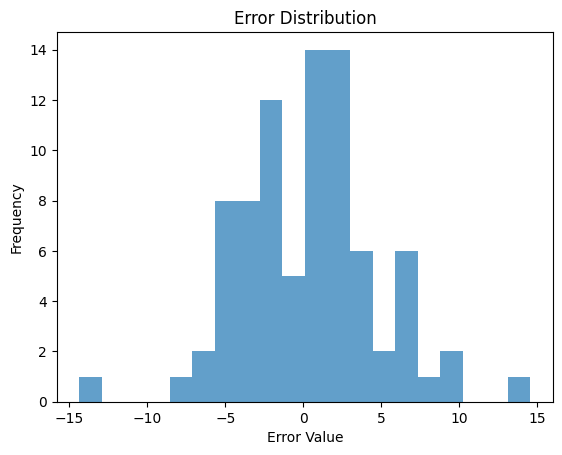

In [881]:
#Error verification
mse = mean_squared_error(results['Actual'], results['Predicted'])
mae = mean_absolute_error(results['Actual'], results['Predicted'])

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

errors = results['Actual'] - results['Predicted']
plt.hist(errors, bins=20, alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.show()